In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
start_token = " "

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

('n samples = ', 7944)
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


('max length =', 16)


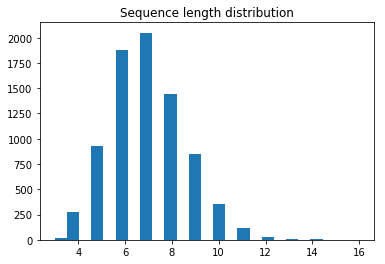

In [4]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

In [5]:
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60



('n_tokens = ', 55)


In [6]:
token_to_id = token_to_id = {x: y for y, x in enumerate(tokens)}###YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens }

In [7]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [8]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 31 29 34 29 32 41  0]
 [ 0  8 41 42 47 52  0  0  0]
 [ 0 19 47 36 46 46 36 32  0]
 [ 0  8 36 42 51 29 43 43 32]]


In [9]:
import keras
from keras.layers import Concatenate, Dense, Embedding

rnn_num_units = 100
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings

# Dense layer that maps input and previous state to new hidden state, [x_t,h_t] -> h_t+1
get_h_next = Dense(rnn_num_units, activation='relu')

# Dense layer that maps current hidden state to probabilities of characters [h_t+1] -> P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax')

# Note: please either set the correct activation to Dense or write it manually in rnn_one_step

Using TensorFlow backend.


In [10]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    
    Follow inline isntructions to complete the function.
    """
    # Convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    
    # Concatenate x embedding and previous h state
    x_and_h = tf.concat([x_t_emb, h_t], 1)
    
    # Compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # Get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

In [11]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

In [12]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [14]:
loss = tf.reduce_mean(tf.reduce_sum(-answers_matrix*tf.log(tf.clip_by_value(predictions_matrix, 1e-4, 1.0)),
                                    reduction_indices=[1], keepdims=None, axis=None))
optimize = tf.train.AdamOptimizer().minimize(loss)

In [15]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

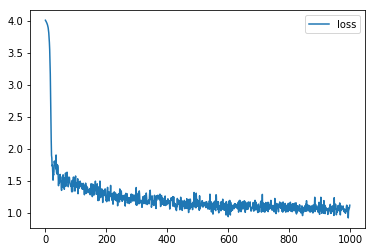

In [16]:

for i in range(1000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [17]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [19]:
def generate_sample(seed_phrase=' ',max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [21]:
for _ in range(50):
    print(generate_sample())

 Nancha         
 Cyan           
 Crennia        
 Someme         
 Roilil         
 Matheel        
 Gerla          
 Jernine        
 Morenor        
 Narila         
 Gjinem         
 Beisey         
 Ady            
 Koll           
 Wot  le        
 Geoxline       
 Malsie         
 Dinfe          
 Racili         
 Hezuite        
 Pade           
 Gietha         
 Rinaci         
 Rudgy          
 Nobegel        
 Kerpie         
 Caxica         
 Anlynt         
 Matdea         
 Dorisa         
 Layd           
 Svenle         
 Melisa         
 Esona          
 Liacolda       
 Lat            
 Clynla         
 Tarzein        
 Diy            
 Heorga         
 Alobanpe       
 Leos           
 Ranala         
 Solpe          
 Wahlie         
 Heinp          
 Aggynne        
 Dercinay       
 Udo            
 Alamira        
